<a href="https://colab.research.google.com/github/linhnguyen222/DPS-Silo/blob/master/unified_LSTM_GloVe_multiclass_and_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###LSTM using GLOVE for full sentence multiclass and binary classification

In [135]:
import numpy as np
import tensorflow as tf
import keras
import pathlib 
from pathlib import Path
import numpy as np
import pandas as pd
#from pytorch_pretrained_bert import BertTokenizer
import torch
from pandas import DataFrame


###Setting the helper functions to read in the data.



In [136]:
def read_data(directory):
    ids = []
    texts = []
    labels = []
    for f in directory.glob('*.txt'):
        id = f.name.replace('article', '').replace('.txt','')
        ids.append(id)
        texts.append(f.read_text())
        labels.append(parse_label(f.as_posix().replace('.txt', '.labels.tsv')))
    # labels can be empty 
    return ids, texts, labels

def clean_text(articles, ids):
    texts = []
    for article, id in zip(articles, ids):
        sentences = article.split('\n')
        start = 0
        end = -1
        res = []
        for sentence in sentences:
           start = end + 1
           end = start + len(sentence)  # length of sequence 
           if sentence != "": # if not empty line
               res.append([id, sentence, start, end])
        texts.append(res)
    return texts


def make_dataset(directory):
    ids, texts, labels = read_data(directory)
    texts = clean_text(texts, ids)
    res = []
    for text, label in zip(texts, labels):
        # making positive examples
        tmp = [] 
        pos_ind = [0] * len(text)
        for l in label:
            for i, sen in enumerate(text):
                if l[0] >= sen[2] and l[0] < sen[3] and l[1] > sen[3]:
                    l[4] = 1
                    tmp.append(sen + [l[0], sen[3], l[2], l[3], l[4]])
                    pos_ind[i] = 1
                    l[0] = sen[3] + 1
                elif l[0] != l[1] and l[0] >= sen[2] and l[0] < sen[3] and l[1] <= sen[3]: 
                    tmp.append(sen + l)
                    pos_ind[i] = 1
        # making negative examples
        dummy = [0, 0, 'O', 0, 0]
        for k, sen in enumerate(text):
            if pos_ind[k] != 1:
                tmp.append(sen+dummy)
        res.append(tmp)     
    return res

def parse_label(label_path):
    labels = []
    f= Path(label_path)
    
    if not f.exists():
        return labels

    for line in open(label_path):
        parts = line.strip().split('\t')
        labels.append([int(parts[2]), int(parts[3]), parts[1], 0, 0])
    labels = sorted(labels) 

    if labels:
        length = max([label[1] for label in labels]) 
        visit = np.zeros(length)
        res = []
        for label in labels:
            if sum(visit[label[0]:label[1]]):
                label[3] = 1
            else:
               visit[label[0]:label[1]] = 1
            res.append(label)
        return res 
    else:
        return labels

In [137]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [138]:
dataset=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/train'))


In [139]:
#train dataframe
empty=[]
for i in dataset:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df=pd.concat(empty)  
df = df.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df.prop.value_counts()
df=df.reset_index()
#del df['index']

#df.head()


In [140]:
print("Size of train set is: ", df.shape[0])

Size of train set is:  15752


In [141]:
dataset_test=make_dataset(Path('/content/drive/My Drive/DSP/data/protechn_corpus_eval/test'))


In [142]:

#test dataframe
empty=[]
for i in dataset_test:
    
    temp=DataFrame(i, columns=['id', 'full_sent', 'start_sent', 'end_sent', 'start_prop', 'end_prop','prop', 'ex1', 'ex2' ])
    empty.append(temp)

df_test=pd.concat(empty)  
df_test = df_test.drop(['ex1'],axis =1).drop(['ex2'],axis =1)
df_test.prop.value_counts()
df_test=df_test.reset_index()
#del df['index']

#df_test.head()


In [143]:
#We code the labels to integers
"""
possible_labels=df.prop.unique()
label_dict={}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label]=index
print(label_dict)
"""
label_dict={'O': 0, 'Black-and-White_Fallacy': 1, 'Loaded_Language': 2, 'Flag-Waving': 3, 
 'Name_Calling,Labeling': 4, 'Slogans': 5, 'Causal_Oversimplification': 6, 'Whataboutism': 7,
 'Exaggeration,Minimisation': 8, 'Doubt': 9, 'Appeal_to_Authority': 10, 'Repetition': 11, 'Appeal_to_fear-prejudice': 12,
 'Thought-terminating_Cliches': 13, 'Bandwagon': 14, 'Red_Herring': 15, 'Reductio_ad_hitlerum': 16,
 'Obfuscation,Intentional_Vagueness,Confusion': 17, 'Straw_Men': 18}

label_dict
#For both test and train set
df['label']=df.prop.replace(label_dict)
df_test['label']=df_test.prop.replace(label_dict)


In [144]:
#train set
df.head()

,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label
0,0,7618745059,“They interpreted the law in my case to say it...,1695,1873,1831,1872,Whataboutism,7
1,1,7618745059,Two guys on my ship did the same thing and wer...,1905,1977,1925,1976,Whataboutism,7
2,2,7618745059,“They used me as an example because of [the ba...,2312,2454,2312,2388,Causal_Oversimplification,6
3,3,7618745059,The government actively destroyed his life an ...,2710,2819,2725,2782,"Exaggeration,Minimisation",8
4,4,7618745059,Ex-Sailor Pardoned By Trump Says He’s SUING Ob...,0,59,0,0,O,0


In [145]:
df.isnull().sum()

index         0
id            0
full_sent     0
start_sent    0
end_sent      0
start_prop    0
end_prop      0
prop          0
label         0
dtype: int64

In [146]:
#test set
df_test.head()

,index,id,full_sent,start_sent,end_sent,start_prop,end_prop,prop,label
0,0,111111133,"CNN in turn dropped its lawsuit on the matter,...",301,415,358,367,Loaded_Language,2
1,1,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,460,465,Loaded_Language,2
2,2,111111133,But while it yielded to Mr. Acosta — whose tes...,417,673,504,507,Loaded_Language,2
3,3,111111133,The White House sought to blame Mr. Acosta for...,967,1167,1070,1077,Loaded_Language,2
4,4,111111133,Codifying the behavior of journalists struck s...,1168,1391,1224,1244,Loaded_Language,2


In [147]:
df_test.isnull().sum()

index         0
id            0
full_sent     0
start_sent    0
end_sent      0
start_prop    0
end_prop      0
prop          0
label         0
dtype: int64

In [148]:
df_all = pd.concat([df, df_test])



In [149]:
print(df_all.shape[0])

20242


In [150]:
del df_all['index']
df_all=df_all.reset_index()
del df_all['index']



In [151]:
#check to see indexes are set in order even after the size of train is over (after 15752)
print(df_all.iloc[15750:15759])

              id  ... label
15750  752287274  ...     0
15751  752287274  ...     0
15752  111111133  ...     2
15753  111111133  ...     2
15754  111111133  ...     2
15755  111111133  ...     2
15756  111111133  ...     2
15757  111111133  ...     2
15758  111111133  ...     2

[9 rows x 8 columns]


###Here we handle the problem that some sentences have more than 1 label. First group by the dataframe on the basis of similar full_length sentences (unique full sentences which some of which might have more than 1 label).

In [152]:
groupedbysent = df_all.groupby('full_sent')


###We make up a new set with unique sentences (no sentence reptition -with varying labels- from this point onward).


In [153]:
all_tokenized_labels=[]
#we make up a new set with unique sentences (no reptition from this point on)
new=df_all['full_sent'].unique()

for i in range (len(groupedbysent)):
    #get the group of each unique sentence and set it as group variable
    group=groupedbysent.get_group(new[i])
    group_labels=group['label']
    temp=[]
    for j in range (group_labels.size):
        temp.append(group_labels.iloc[j])
    all_tokenized_labels.append(temp)
    
      #one hot format
      #evey single sentence can belong to classes among existing 19 classes
all_encoded=np.zeros((len(groupedbysent), 19)) 

for i in range (len(groupedbysent)):    
    for  idx, val in enumerate (all_tokenized_labels[i]):
        all_encoded[i][val]=1  

In [154]:
all_tokenized_labels[0]

[7, 0, 0, 7, 7]

###It can be checked if the labels are correctly exctracted for every single sentence:

In [155]:
#for example we can check this for the first sentence
print("The first sentence of the dataset is: ", new[0])

The first sentence of the dataset is:  “They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.


In [156]:
#g=groupedbysent.get_group('“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.')

In [157]:
#check how many times a particular sentence is repeated in the whole dataset. 
#also return all its corresponding labels 
count=0
particular_sent_labels=[]
for i in range (df_all.shape[0]):
  if df_all['full_sent'][i]== '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.':
    count +=1
    particular_sent_labels.append(df_all['label'][i])

print("The sentence is repeated this many times in dataset: ", count)
print("Its multi labels accordingly are: ", particular_sent_labels)

The sentence is repeated this many times in dataset:  5
Its multi labels accordingly are:  [7, 0, 0, 7, 7]


###The new data set now contains each sentence once. The "all_encoded" contains the labels of each unique sentence. This has less data points than the original dataset as now every sentence is uniqe and repeated only once.

In [158]:
print(len(all_encoded))
print(len(new))

16285
16285


In [159]:
print(all_encoded[116])
print(new[116])
#print(df_all.iloc[1,1])
#print(df_all.iloc[0,6])

[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
“He is just looking for attention and doesn’t want people to look at his past record and relationships - a total low-life!”


In [160]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

###In the following steps,  the key model parameters are defined and data is split. “MAX_NB_WORDS” sets the maximum number of words to consider as features for tokenizer. “MAX_SEQUENCE_LENGTH” cuts off texts after this number of words (among the MAX_NB_WORDS most common words). “VALIDATION_SPLIT” sets a portion of data for validation and not used in training. “EMBEDDING_DIM” defines the size of the “vector space”. “GLOVE_DIR” defines the GloVe file directory. Split the data into the texts and the labels.

In [161]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [162]:
#train=df_all.iloc[:15752]
#test=df_all.iloc[15752:]
#comments_train = train['full_sent']
#comments_test = test['full_sent']
#comments_train = list(comments_train)
#comments_train=new[:14000]
#comments_test=new[14000:]

In [163]:
print(comments_train[0])

“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.


In [250]:
#labels=['binary']
#y = train[labels].values
y=all_encoded


###In the following step, we remove stopwords, punctuation and make sentences  lowercase.


In [165]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")

In [166]:
#print("size of train set is: ", len(comments_train))
#print("size of test set is: ", len(comments_test))

size of train set is:  14000
size of test set is:  2285


In [167]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [248]:
texts = [] 

for line in tqdm_notebook(new, total=12000): 
    texts.append(clean_text(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [251]:
print('Sample data:', texts[1], y[1])

Sample data: wo guys ship thing werent treated crimin [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


###We create a tokenizer, configured to only take into account the MAX_NB_WORDS most common words. Next the word index is built. The word index that was computed can be recovered.


In [252]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [253]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 26981


###Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen). Pad after each sequence.

In [254]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (16285, 200)
Shape of label tensor: (16285, 19)


In [255]:
#Shuffle the data in train set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [256]:
#create train and validation split
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [257]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [9256.  111. 1553.  241.  787.  123.  185.   60.  364.  474.  141.  478.
  278.   75.   13.   32.   52.   12.   12.]
validation:  [2.308e+03 2.300e+01 3.900e+02 5.400e+01 2.130e+02 2.800e+01 4.200e+01
 1.900e+01 9.600e+01 1.330e+02 3.500e+01 1.160e+02 5.700e+01 1.500e+01
 2.000e+00 8.000e+00 6.000e+00 5.000e+00 2.000e+00]


In [261]:
print('Tokenized sentences: \n', data[11])
print('One hot label: \n', labels[11])

Tokenized sentences: 
 [ 5535   837   188  2355  1909   694  4409 25449  5170  3155  1205     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [262]:
print("size of train set is: ", len(x_train))
print("size of test set is: ", len(x_val))

size of train set is:  13028
size of test set is:  3257


###Pre-trained GloVe vectors from Stanford is used to create an index of words mapped to known embeddings, by parsing the data dump of pre-trained embeddings.Then  word embeddings are loaded into an embeddings_index.


In [263]:
data_root = pathlib.Path('/content/drive/My Drive/DSP/torchtextclassification-nov20-2020/')


In [264]:
embeddings_index = {}
f = open(data_root/'glove.6B.100d.txt')
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


###The embedding layers are created. It specifies the maximum input length to the Embedding layer and makes use of the output from the previous embedding layer which outputs a 3-D tensor into the LSTM layer.Use a Global Max Pooling layer to to reshape the 3D tensor into a 2D one. The dropout layer is set to drop out 10% of the nodes. The Dense layer is defined to produce a output dimension of 50. We feed the output into a Dropout layer again. Finally, we feed the output into a “Sigmoid” layer.

In [265]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

 ####Activation is set to sigmoid, because the labels are  independent

In [266]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(19, activation="sigmoid")(x)

In [267]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          2698200   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)               

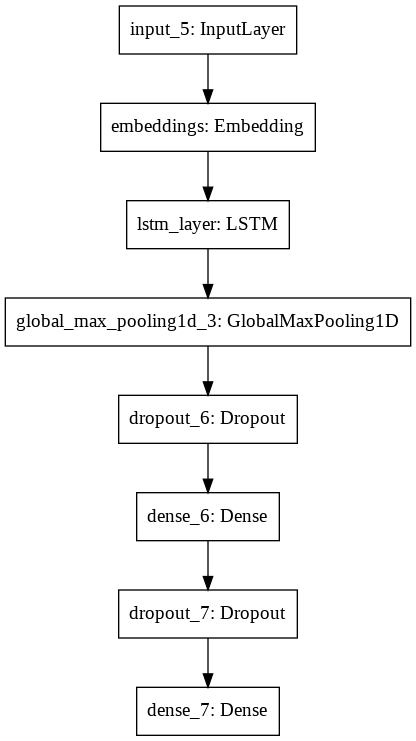

In [268]:
tf.keras.utils.plot_model(model)

In [269]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 100, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/100
408/408 [==============================] - 5s 13ms/step - loss: 1.6939 - accuracy: 0.7042 - val_loss: 1.4506 - val_accuracy: 0.7086
Epoch 2/100
408/408 [==============================] - 5s 12ms/step - loss: 1.4711 - accuracy: 0.7111 - val_loss: 1.4183 - val_accuracy: 0.7086
Epoch 3/100
408/408 [==============================] - 5s 12ms/step - loss: 1.4291 - accuracy: 0.7151 - val_loss: 1.3951 - val_accuracy: 0.7111
Epoch 4/100
408/408 [==============================] - 5s 12ms/step - loss: 1.3921 - accuracy: 0.7224 - val_loss: 1.3803 - val_accuracy: 0.7206
Epoch 5/100
408/408 [==============================] - 5s 12ms/step - loss: 1.3600 - accuracy: 0.7284 - val_loss: 1.3799 - val_accuracy: 0.7197
Epoch 6/100
408/408 [==============================] - 5s 12ms/step - loss: 1.3299 - accuracy: 0.7337 - val_loss: 1.3867 - val_accuracy: 0.7175
Epoch 7/100
408/408 [==============================] - 5s 12ms/step - loss: 1.2926 - accuracy: 0.7396 - val_loss: 1.3

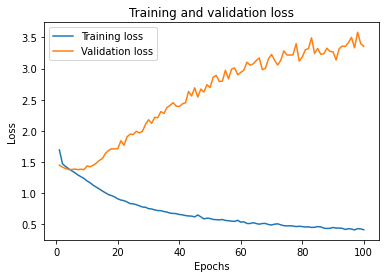

In [270]:
import matplotlib.pyplot as plt 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

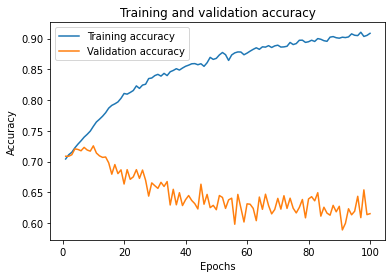

In [271]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [272]:
pred = model.predict(x_val)
print("size of predicted array is: ", len(pred))
print("size of Y_test array is: ", len(y_val))

size of predicted array is:  3257
size of Y_test array is:  3257


In [273]:
print(y_val[0])


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [274]:
print(pred[400])


[5.6127668e-05 2.5572442e-08 8.1657338e-01 2.0552385e-03 2.3351289e-05
 9.3884855e-09 1.2457698e-06 2.0812027e-05 1.6624093e-01 1.4164613e-03
 1.7853026e-06 2.0137383e-04 1.0019810e-03 5.0616662e-09 4.2697668e-11
 7.5929231e-05 2.0884762e-08 7.2547664e-08 3.9217185e-14]


In [275]:
np.argmax(pred[400])

2

We find the index of the highest value (predicted class). 


In [276]:
pred1=[]
for i in range (len(pred)):
  pred1.append(np.argmax(pred[i]))

In [277]:
Y_test1=[]
for i in range (len(pred)):
  Y_test1.append(np.argmax(y_val[i]))

In [278]:
from sklearn.metrics import precision_recall_fscore_support as score

#predicted = [1,2,3,4,5,1,2,1,1,4,5] 
#y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(Y_test1, pred1 )

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



precision: [0.7831274  0.09090909 0.31609195 0.09756098 0.16564417 0.
 0.         0.         0.03125    0.07692308 0.04545455 0.11538462
 0.04651163 0.125      0.         0.         0.25       0.
 0.        ]
recall: [0.79636049 0.05       0.28947368 0.10526316 0.17532468 0.
 0.         0.         0.01724138 0.09677419 0.04761905 0.13043478
 0.05263158 0.11111111 0.         0.         0.33333333 0.
 0.        ]
fscore: [0.78968851 0.06451613 0.3021978  0.10126582 0.170347   0.
 0.         0.         0.02222222 0.08571429 0.04651163 0.12244898
 0.04938272 0.11764706 0.         0.         0.28571429 0.
 0.        ]
support: [2308   20  380   38  154   17   29    9   58   93   21   69   38    9
    0    6    3    4    1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [279]:
df1 = pd.DataFrame({ 'precision': precision, 'recall':recall, 'Fscore':fscore, 'support':support })


In [280]:
from tabulate import tabulate
print(tabulate(df1, headers='keys', tablefmt='psql'))


+----+-------------+-----------+-----------+-----------+
|    |   precision |    recall |    Fscore |   support |
|----+-------------+-----------+-----------+-----------|
|  0 |   0.783127  | 0.79636   | 0.789689  |      2308 |
|  1 |   0.0909091 | 0.05      | 0.0645161 |        20 |
|  2 |   0.316092  | 0.289474  | 0.302198  |       380 |
|  3 |   0.097561  | 0.105263  | 0.101266  |        38 |
|  4 |   0.165644  | 0.175325  | 0.170347  |       154 |
|  5 |   0         | 0         | 0         |        17 |
|  6 |   0         | 0         | 0         |        29 |
|  7 |   0         | 0         | 0         |         9 |
|  8 |   0.03125   | 0.0172414 | 0.0222222 |        58 |
|  9 |   0.0769231 | 0.0967742 | 0.0857143 |        93 |
| 10 |   0.0454545 | 0.047619  | 0.0465116 |        21 |
| 11 |   0.115385  | 0.130435  | 0.122449  |        69 |
| 12 |   0.0465116 | 0.0526316 | 0.0493827 |        38 |
| 13 |   0.125     | 0.111111  | 0.117647  |         9 |
| 14 |   0         | 0         

In [281]:
from sklearn.metrics import f1_score

In [282]:
f1_score(Y_test1, pred1, average='weighted')

0.6113867522615675

###Binary classification of propaganda versus non propaganda sentences

In [283]:
for i in range (0, df_all.shape[0]):
    if df_all.iloc[i]['label']==0  :
        
        df_all.at[i, 'binary']= 0 
    else:
        #False
        df_all.at[i, 'binary']= 1 
        

In [284]:
print(df_all.shape[0])

20242


In [285]:
comments_train_binary=df_all['full_sent']

In [231]:
"""comments_train_binary=all_sentences[:16000]
comments_test_binary=all_sentences[16000:]
print("size of train set is: ", len(comments_train_binary))
print("size of test set is: ", len(comments_test_binary))"""

size of train set is:  16000
size of test set is:  4242


In [286]:
y=df_all['binary']

In [287]:
texts = [] 

for line in tqdm_notebook(comments_train_binary, total=12000): 
    texts.append(clean_text(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [288]:
print('Sample data:', texts[1], y[1])

Sample data: wo guys ship thing werent treated crimin 1.0


In [289]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [290]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 26981


In [291]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (20242, 200)
Shape of label tensor: (20242,)


In [305]:
np_array=np.asarray(y)
y = np_array.reshape(20242,1)
y.shape


(20242, 1)

In [306]:
#Shuffle the data in train set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [307]:
#create train and validation split
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [308]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [  417    10  2506  3964  7192   357   341   118  3231 14136    73   118
  1129  1162  1012  4172     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [309]:
print("size of train set is: ", len(x_train))
print("size of test set is: ", len(x_val))

size of train set is:  16194
size of test set is:  4048


In [310]:
embeddings_index = {}
f = open(data_root/'glove.6B.100d.txt')
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [311]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [315]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [316]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          2698200   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 60)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)              

In [317]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 100, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/100
507/507 [==============================] - 7s 14ms/step - loss: 0.6463 - accuracy: 0.6566 - val_loss: 0.6395 - val_accuracy: 0.6630
Epoch 2/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6431 - accuracy: 0.6578 - val_loss: 0.6449 - val_accuracy: 0.6630
Epoch 3/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6415 - accuracy: 0.6578 - val_loss: 0.6404 - val_accuracy: 0.6630
Epoch 4/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6374 - accuracy: 0.6578 - val_loss: 0.6424 - val_accuracy: 0.6630
Epoch 5/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6327 - accuracy: 0.6582 - val_loss: 0.6405 - val_accuracy: 0.6630
Epoch 6/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6251 - accuracy: 0.6618 - val_loss: 0.6456 - val_accuracy: 0.6623
Epoch 7/100
507/507 [==============================] - 6s 12ms/step - loss: 0.6111 - accuracy: 0.6693 - val_loss: 0.6

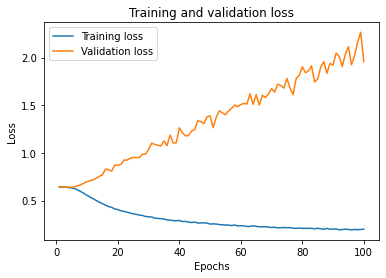

In [318]:
import matplotlib.pyplot as plt 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

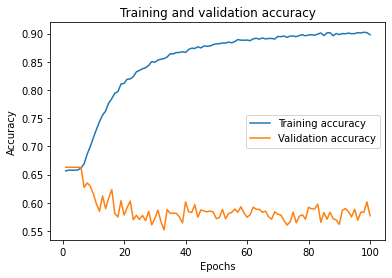

In [319]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [332]:
pred = model.predict(x_val)
print("size of predicted array is: ", len(pred))
print("size of Y_test array is: ", len(y_val))

size of predicted array is:  4048
size of Y_test array is:  4048


In [346]:
print(y_val[0])


[0.]


In [360]:
print(pred[11])


[0.00010278]


In [361]:
pred1=[]
for i in range (len(pred)):
  if pred[i]>0.5:
    pred1.append(1)
  else:
    pred1.append(0)

In [362]:
Y_test1=[]
for i in range (len(pred)):
  if y_val[i]>0.5:
    Y_test1.append(1)
  else:
    Y_test1.append(0)

In [363]:
print(len(pred1))
print(len(Y_test1))

4048
4048


In [355]:
print(Y_test1[1])

1


In [364]:
from sklearn.metrics import precision_recall_fscore_support as score

#predicted = [1,2,3,4,5,1,2,1,1,4,5] 
#y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(Y_test1, pred1)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



precision: [0.66632444 0.34547069]
recall: [0.72540984 0.28519062]
fscore: [0.69461291 0.3124498 ]
support: [2684 1364]


In [365]:
df1 = pd.DataFrame({ 'precision': precision, 'recall':recall, 'Fscore':fscore, 'support':support })


In [366]:
from tabulate import tabulate
print(tabulate(df1, headers='keys', tablefmt='psql'))


+----+-------------+----------+----------+-----------+
|    |   precision |   recall |   Fscore |   support |
|----+-------------+----------+----------+-----------|
|  0 |    0.666324 | 0.72541  | 0.694613 |      2684 |
|  1 |    0.345471 | 0.285191 | 0.31245  |      1364 |
+----+-------------+----------+----------+-----------+
